In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt 

objp = np.zeros((6*9, 3), np.float32)
objp[:,:2]=np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/*.jpg')

In [2]:
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        if idx == np.random.randint(0, 20):
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            # write_name = 'output_images/corners_found'+str(idx)+'.jpg'
            # cv2.imwrite(write_name, img)
            # cv2.imshow('img', img)
            plt.imshow(img)        
            plt.show()
#             cv2.waitKey(500)

In [3]:
img = cv2.imread('./camera_cal/calibration4.jpg')
img_size = (img.shape[1], img.shape[0]) 

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./output_images/calibration1_undist.jpg', dst)

True

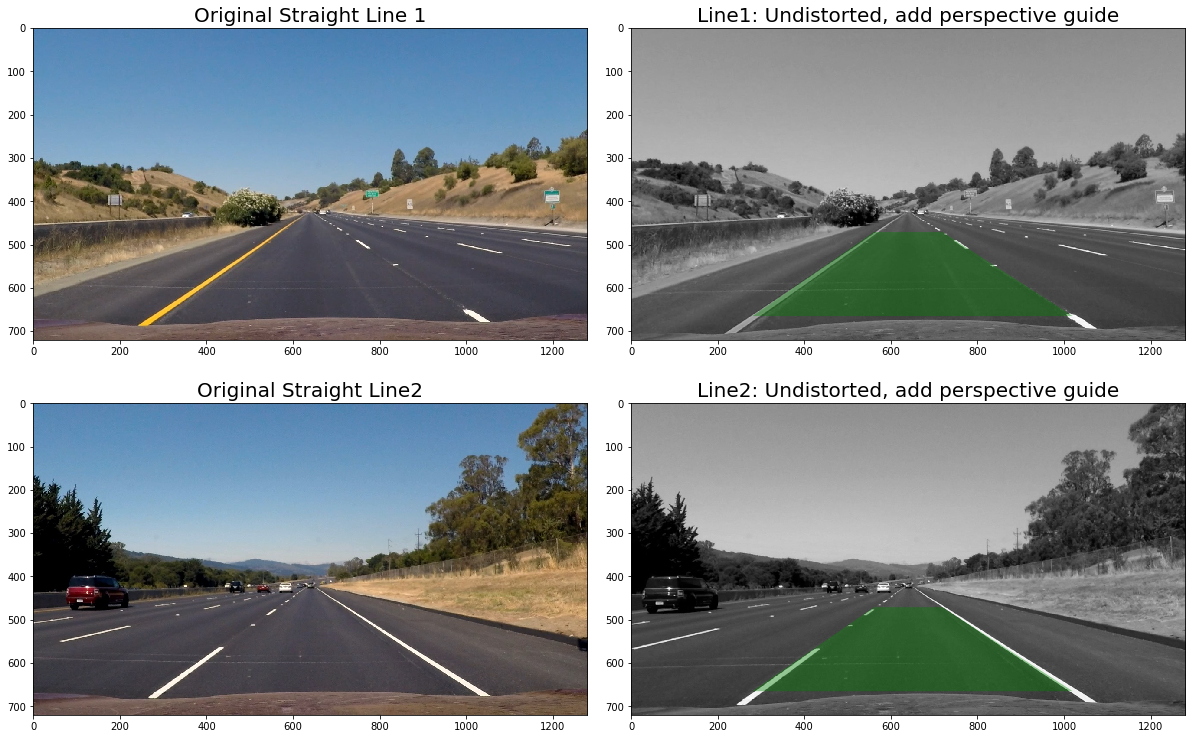

In [74]:
# step 3 Color/gradient threshold
test_imgs = glob.glob('./test_images/*.jpg')
sr_img1 = cv2.cvtColor(cv2.imread(test_imgs[0]), cv2.COLOR_BGR2RGB)
sr_img2 = cv2.cvtColor(cv2.imread(test_imgs[1]), cv2.COLOR_BGR2RGB)
str_img1 = cv2.cvtColor(sr_img1, cv2.COLOR_BGR2GRAY)
str_img2 = cv2.cvtColor(sr_img2, cv2.COLOR_BGR2GRAY)
cv2.imwrite('./output_images/straight_Line_Gray.jpg', str_img1)

# undistord image
str_img1 = cv2.undistort(str_img1, mtx, dist, None, mtx)
str_img2 = cv2.undistort(str_img2, mtx, dist, None, mtx)
img_size = (str_img1.shape[1], str_img1.shape[0])

# define the 4 corners for perspective image
tilt_corners = np.array([[561, 471], 
                         [280, 665], 
                         [1020, 665], 
                         [719, 471]])

edge_distance = 350
dst_corners = np.array([[edge_distance, 445], 
                         [edge_distance, 665], 
                         [img_size[0]-edge_distance, 665], 
                         [img_size[0]-edge_distance, 445]])

x_size = img_size[0]
y_size = img_size[1]
vertices = np.array([[(0.15*x_size, 0.95*y_size), (0.42*x_size, 0.6*y_size),
                    (0.58 * x_size, 0.6 * y_size), (0.95*x_size, 0.95*y_size)]], dtype=np.int32) # define polygon for mask
# draw patch to show which area is been corrected 
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
patches = []
tilt_corners_polygon = np.append(tilt_corners[:,:2], tilt_corners[0,:2]).reshape((5, 2))
polygon = Polygon(tilt_corners_polygon, True)
patches.append(polygon)
p = PatchCollection(patches, alpha=0.4)
p.set_facecolor('g')

%matplotlib inline
f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 9))
f.tight_layout()
ax1.imshow(sr_img1)
# ax1.add_collection(p)
ax1.set_title('Original Straight Line 1', fontsize=20)

p = PatchCollection(patches, alpha=0.4)
p.set_facecolor('g')
ax2.imshow(str_img1, cmap='gray')
ax2.add_collection(p)
ax2.set_title('Line1: Undistorted, add perspective guide', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax3.imshow(sr_img2)
# ax1.add_collection(p)
ax3.set_title('Original Straight Line2', fontsize=20)

p = PatchCollection(patches, alpha=0.4)
p.set_facecolor('g')
ax4.imshow(str_img2, cmap='gray')
ax4.add_collection(p)
ax4.set_title('Line2: Undistorted, add perspective guide', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.8, bottom=-0.3)

In [225]:
def image_mask(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    img = np.copy(image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #because this uses mpimg to read image
    sobel = cv2.Sobel(gray, cv2.CV_64F, int(orient=='x'*1) + int(orient=='y'*0),int(orient=='x'*0) + int(orient=='y'*1))
    sobel = np.absolute(sobel)
    sobel = np.uint8(255*sobel/np.max(sobel))
    grad_binary = np.zeros_like(sobel)
    grad_binary[(sobel >= thresh[0])&(sobel <= thresh[1])] = 1

    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    image = np.copy(img)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel = np.uint8(255*sobel/np.max(sobel))
    mag_binary = np.zeros_like(sobel_x)
    mag_binary[(sobel>=mag_thresh[0])&(sobel<=mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    image = np.copy(img)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    direction = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return dir_binary

def color_filter(image, s_thresh=(170, 255)):
    img = np.copy(image)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:, :, 2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary

# Define perspective transform function
def unwarp(img):
    # Define calibration box in source(original) and destination (warped) corordinates
    img_size = (img.shape[1], img.shape[0])
    
    # Four source coordinates
    src = np.float32(tilt_corners)
    # Four desired coordinates
    dst = np.float32(dst_corners)
    
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Could compute the invert also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)    
    return warped

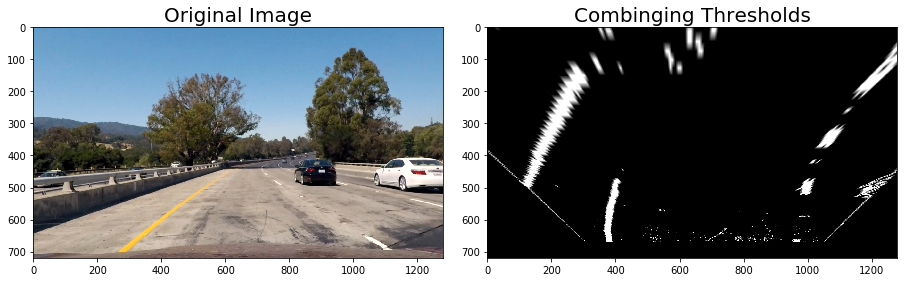

In [259]:
import matplotlib.image as mpimg
# Read in an image
img = mpimg.imread('./test_images/test1.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
image = image_mask(img, vertices)

def combined_filter(image):
    # Choose a Sobel kernel size
    ksize = 7 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(40, 130))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(40, 170))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.9, 1.1))
    hls_binary = color_filter(image, s_thresh=(170,255))
    # calculate the combined image
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) | (hls_binary == 1))] = 1
    return combined

combined = image_mask(combined_filter(image), vertices)
warped = warp(combined)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Combinging Thresholds', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

Text(0.5,1,'window fitting results')

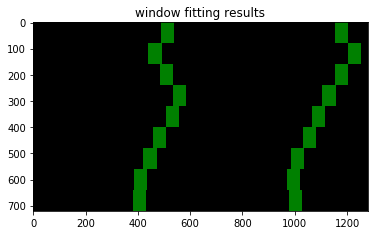

In [255]:
# find the lines and fit

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 50 # How much to slide left and right for searching
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
    # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)
# If we found any window centers
if len(window_centroids) > 0:
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 200) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255        
    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.array(np.dstack((warped, warped, warped))*255,np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
# if no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')

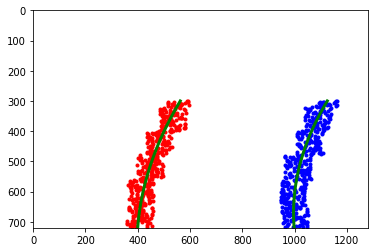

In [256]:
# measuring curvature
ploty = np.linspace(300, 719, num=420)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case
rev_win_cen = window_centroids[::-1]
leftx = np.array([rev_win_cen[int(y//window_height)][0] + np.random.randint(-50, high=51)
                              for y in ploty])
rightx = np.array([rev_win_cen[int(y//window_height)][1] + np.random.randint(-50, high=51)
                                for y in ploty])

# leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
# rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# Plot up the data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

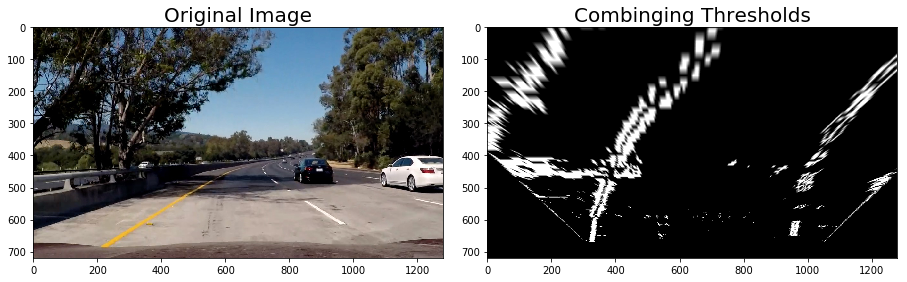

In [235]:
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# f.tight_layout()
# ax1.imshow(img)
# ax1.set_title('Original Image', fontsize=20)
# ax2.imshow(warped, cmap='gray')
# ax2.set_title('Combinging Thresholds', fontsize=20)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)